# Data gemeenteraadsverkiezingen 2022 Nederland

Dit notebook is voor het verwerken van de data van de gemeenteraadsverkiezingen van 2022. Er zal hier stap voor stap door de data gelopen worden om het proces reproduceerbaar te maken voor latere verkiezingen. De eerste stap was de data ophalen van de bronnen, zowel de overheid als waar is mijn stemlokaal (voor geografische data van de stemlokalen). De bronnen gebruikt voor de data zijn voor de verkiezingen van 2022 is als volgt:

- [Verkiezingsuitslagen Gemeenteraad 2022](https://data.overheid.nl/dataset/verkiezingsuitslagen-gemeenteraad-2022#panel-resources)
  - [Directe link naar uitslagen per gemeente CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_osv4-3_2022-03-24T15.33.zip)
  - [Directe link naar kandidatenlijst met uitslagen CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_alle-kandidaten_2022-02-22T08.34.csv)
- [Waar is mijn stemlokaal stembureau data](https://waarismijnstemlokaal.nl/data)
  - [Directe link naar waar is mijn stemlokaal gemeenteraad 2022 CSV (CKAN)](https://ckan.dataplatform.nl/datastore/dump/d6a1b4c4-73c8-457b-9b75-a38428bded68)
  - [Verkiezingsuitslagen gemeenteraadsverkiezingen 2022 geodata (Volkskrant)](https://data.openstate.eu/dataset/verkiezingsuitslagen-gemeenteraadsverkiezingen-2022)
    - [Directe link naar GEOJSON bestand](https://data.openstate.eu/dataset/a1767f1b-bf0c-409b-b3b1-3af9954b57f4/resource/413be255-5070-48f4-b631-895097976abb/download/2022gr.geo.json)
- [CBS Wijk- en buurtkaart 2021](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2021)
  - [Directe link naar zip bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip)
- [CBS bevolkingsdichtheid kaart](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-100-meter-bij-100-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/100/nl_vierkant_100meter_bij_100meter.7z)

De eerste stap die we moeten maken is de data importeren voor de analyse, daarna kunnen we kijken hoe goed de data is, hoe we het aan kunnen vullen, en wat er mee te doen. De makkelijkste structuur die we vonden was het geojson bestand van open state en de Volkskrant, daar staan alle stembureaus al in een lijst, en we hebben een makkelijk framework om het te importeren; geopandas. We laden deze dan ook als eerste in.

In [40]:
import pandas as pd
import geopandas as gpd

crs = {'init':'EPSG:4326'}
df_geojson = gpd.read_file(r'../data/2022gr.geo.json', crs=crs)

/home/lillian/.local/lib/python3.9/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 61
  self._schema = self.session.get_schema()
/home/lillian/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: UserWarning: Empty field name at index 61
  for feature in features_lst:


We importeren nu de gemeente shapefile kaart van het CBS, om de overlay van onze stemlokalen eroverheen te kunnen doen. 

<AxesSubplot:>

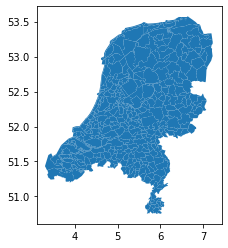

In [41]:
nl_map = gpd.read_file(r'../data/shape/Netherlands_shapefile/gemeente_2021_v1.shp')
nl_map.to_crs(epsg=4326).plot()


<AxesSubplot:>

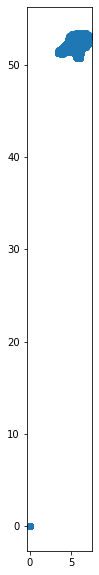

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson.plot(ax=ax)

We hebben hier een probleem dat sommige punten de coördinaten 0,0 hebben, dit is niet iets wat we willen weergeven. Laten we eerst kijken waarom dit het geval is in de data voordat we het er helemaal uithalen.

In [25]:
for index, row in df_geojson.iterrows():
    if (row.geometry.centroid.x == 0.00000):
        print(row)

Stembureau                                                            32
Adres                                                                   
Locatie                                                             SB32
description                               Stembureau Mobiel Stembureau 1
Geldige stemmen                                                       99
                                                       ...              
"Leefbaar 's-Hertogenbosch" Paul Kagie                               NaN
RAADSGROEPERING ''BOSCH-BELANG''                                     NaN
gewoon ge-DREVEN                                                     NaN
VOOR Den Bosch Joep Gersjes                                          NaN
geometry                                                     POINT (0 0)
Name: 2520, Length: 973, dtype: object
Stembureau                                                            33
Adres                                                                   
Locatie     

Het zijn dus duidelijk allemaal mobiele stembureaus, die kunnen we in een aparte dataset houden voor later, voor nu zijn ze onbelangrijk voor de kaartweergave, laten we de dataset dus opsplitsen in drie dataframes, de originele, één frame zonder de mobiele stembureaus, en de mobiele stembureaus alleen.

In [30]:
#de waarschuwing over de projectie die niet klopt kan genegeerd worden, we zoeken naar data die x = 0 is, de projectie gaat geen effect hebben op die data in Nederland
#filter de data en print welke waardes 0 hebben op x
mobiel_mask = df_geojson['geometry'].centroid.x == 0
i = 0
for item in mobiel_mask:
    if item:
        print(i)
    i = i + 1

/tmp/ipykernel_39610/291552514.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mobiel_mask = df_geojson['geometry'].centroid.x == 0


2520
2521
2918
3579
3580
3581
3582
3583
5494
5784
5785
6260
6261
6738
6739
6863
7348
7364
7857
7912
7913
7923
7924
7926
7958
7959
7960
8108
8109
8161
8162
8163
8318
9093
9151
9152
9153
9661
9853
10427
10431
10497
10498
10525
10526
10527
10528
10623
10624
10894
10895
11032
11101
12038
12039
12053
12054
12118
12119
12120
12121
12504
12505
12506


In [34]:
df_geojson_clean = df_geojson[~mobiel_mask]
df_geojson_mobiel = df_geojson[mobiel_mask]
print(df_geojson_mobiel)

       Stembureau   Adres Locatie  \
0               1  9461BH     SB1   
1               2  9461DA     SB2   
2               3  9461JA     SB3   
3               4  9451KD     SB4   
4               6  9454PL     SB6   
...           ...     ...     ...   
12591         703  5391AR   SB703   
12592         705  5391AR   SB705   
12593         750  5382KE   SB750   
12594         751  5382KE   SB751   
12595         752  5283KE   SB752   

                                             description  Geldige stemmen  \
0      Stembureau Gemeentehuis Gieten (postcode: 9461...              784   
1              Stembureau OBS Gieten (postcode: 9461 DA)              562   
2      Stembureau Zorgcentrum Dekelhem (postcode: 946...              566   
3      Stembureau Ontmoetingscentrum Boerhorn Rolde (...             1495   
4      Stembureau Dropshuis de Eekhof (postcode: 9454...              347   
...                                                  ...              ...   
12591  Stemburea

<AxesSubplot:>

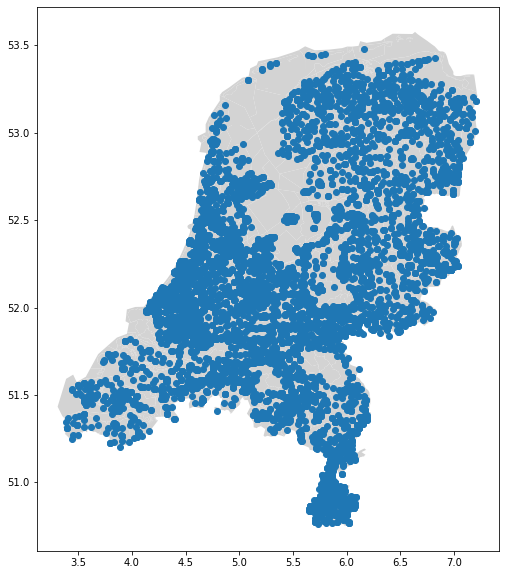

In [37]:
fig, ax = plt.subplots(figsize = (10,10))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

Nu we een mooie kaart hebben van nederland met de stemlokalen erop, kunnen we gaan kijken naar hoe dit verhoud met de bevolkingsdichtheid als eerste voorbeeld. De kaart is opgehaald van het CBS, eerst gaan we kijken hoe de kaart er op zichzelf met dezelfde projectie uitziet.

<AxesSubplot:>

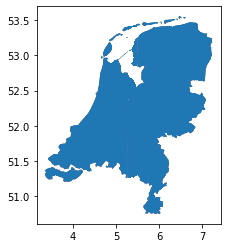

In [39]:
nl_map_dst = gpd.read_file(r'../data/shape/Netherlands_shapefile/NL_vierkant100m.shp')
nl_map_dst.to_crs(epsg=4326).plot(color = green)

In [47]:
print(nl_map_dst)

         C28992R100                                           geometry
0        E2266N6194  POLYGON ((226600.000 619400.000, 226600.000 61...
1        E2267N6194  POLYGON ((226700.000 619500.000, 226800.000 61...
2        E2268N6194  POLYGON ((226800.000 619500.000, 226900.000 61...
3        E2269N6194  POLYGON ((226900.000 619500.000, 227000.000 61...
4        E2270N6194  POLYGON ((227000.000 619500.000, 227100.000 61...
...             ...                                                ...
3723283  E1927N3068  POLYGON ((192700.000 306900.000, 192800.000 30...
3723284  E1921N3067  POLYGON ((192100.000 306800.000, 192200.000 30...
3723285  E1922N3067  POLYGON ((192200.000 306800.000, 192300.000 30...
3723286  E1923N3067  POLYGON ((192300.000 306800.000, 192400.000 30...
3723287  E1924N3067  POLYGON ((192400.000 306800.000, 192500.000 30...

[3723288 rows x 2 columns]


In [ ]:
df_wims = pd.read_csv(r'../data/wims.csv')
print(df_wims)
dfwims.

In [ ]:
#de eerste vijf rijen zijn meta-data en kunnen we gerust weghalen voor nu 
df_gr_gr = pd.read_csv(r'../data/stemmen/01_Groningen/osv4-3_telling_gr2022_groningen.csv', skiprows=5, header=None, delimiter=';')
print(df_gr_gr)


De data is heel gecompliceerd, dus we moeten het bruikbaar maken in pandas. Met hoe de data eruit ziet in een CSV in libre office willen we een constructie maken van de verschillende onderdelen. We hebben de data van de stemlokalen apart al, die kunnen we dus negeren. We willen de data van de lijsten apart hebben. 